In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

## Imporing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        label_num = labels.index(label)
        
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_img_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_img_arr, label_num])
            except Exception as e:
                print(e)
    return data
        

In [4]:
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.4.0) /tmp/pip-req-build-dglzv4yn/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.4.0) /tmp/pip-req-build-dglzv4yn/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.4.0) /tmp/pip-req-build-dglzv4yn/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.4.0) /tmp/pip-req-build-dglzv4yn/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [5]:
train[0]

[array([[ 75,  72,  31, ..., 128, 166, 190],
        [ 60,  50,   0, ..., 127, 171, 196],
        [ 54,   8,   4, ..., 112, 155, 191],
        ...,
        [ 13,  13,  13, ..., 190, 192, 195],
        [ 13,  12,  13, ..., 190, 196, 197],
        [ 13,  12,  13, ..., 190, 193, 197]], dtype=uint8),
 0]

## Data Visualization & Preprocessing

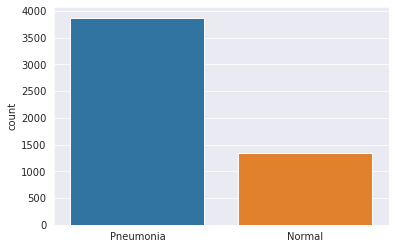

In [6]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)     

## Previewing the images of both the classes

Text(0.5, 1.0, 'PNEUMONIA')

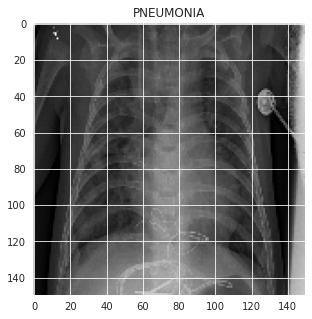

In [7]:
plt.figure(figsize=(5, 5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'NORMAL')

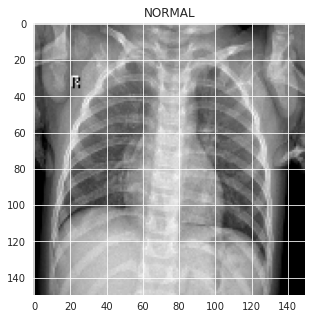

In [8]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

## Train Test Split

In [9]:
def get_feature_and_label(data):
    X, y = [], []
    for feature, label in data:
        X.append(feature)
        y.append(label)
    return X, y

In [10]:
X_train, y_train = get_feature_and_label(train)
X_test, y_test = get_feature_and_label(test)
X_val, y_val = get_feature_and_label(val)

In [11]:
# Normalize the data

X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255
X_val = np.array(X_val) / 255

In [12]:
# resize data for deep learning 
X_train = X_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [13]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

## Creating the model

In [14]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [15]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience = 2, verbose=1,
    factor=0.3, min_lr=0.000001)

In [16]:
history = model.fit(
    datagen.flow(X_train,y_train, batch_size=32),
    epochs=12,
    validation_data=datagen.flow(X_val, y_val),
    callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 12s 74ms/step - loss: 0.3407 - accuracy: 0.8798 - val_loss: 20.6316 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 11s 70ms/step - loss: 0.2059 - accuracy: 0.9187 - val_loss: 18.6292 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.1794 - accuracy: 0.9256
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 13s 81ms/step - loss: 0.1794 - accuracy: 0.9256 - val_loss: 14.3546 - val_accuracy: 0.5000
Epoch 4/12
163/163 [==============================] - 11s 70ms/step - loss: 0.1426 - accuracy: 0.9459 - val_loss: 9.4897 - val_accuracy: 0.5000
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.9526
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [==============================] - 12s 72ms/step - loss: 0.1359 - accura

In [17]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 7ms/step - loss: 0.2515 - accuracy: 0.9119
Loss of the model is -  0.2514941990375519
20/20 [==============================] - 0s 7ms/step - loss: 0.2515 - accuracy: 0.9119
Accuracy of the model is -  91.18589758872986 %


In [18]:
predictions = model.predict_classes(X_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0], dtype=int32)

In [19]:
cm = confusion_matrix(y_test,predictions)
cm

array([[367,  23],
       [ 32, 202]])

In [20]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

## Some correctly predicted classes

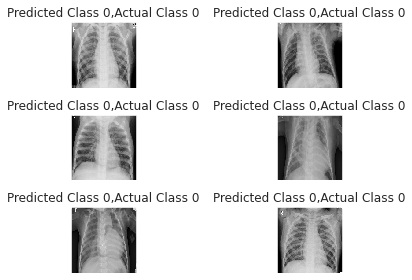

In [21]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

## Some wrongly predicted classes

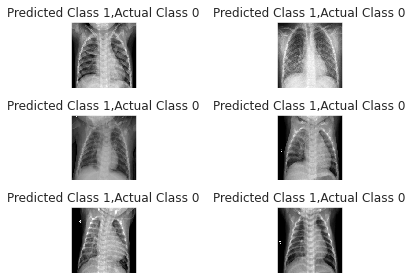

In [22]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1